# **Capstone project: Providing data-driven suggestions for HR**

**Note:** you don't need to download any data to complete this lab. For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

My stakeholders are the HR professionals at Salifort Motors. I will be using the data they've collected to create an employee turnover predictive model. This model will give direction to future retention-focused HR policies. 

My initial observations are that the data has 3008 duplicate rows but no null values. Column names needed to be tidied. There were about 800 right-skewing outliers in the tenure column. There are no ethical considerations in this stage.

### Import packages

In [1]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, make_scorer
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
import pickle




In [2]:
from xgboost import XGBClassifier
from xgboost import plot_importance

### Load dataset

`Pandas` is used to read a dataset called **`HR_capstone_dataset.csv`.**  As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [3]:
# Load dataset into a dataframe
df0 = pd.read_csv("HR_capstone_dataset.csv")


# Display first few rows of the dataframe
df0.head()


satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

## Step 2. Data Exploration (Initial EDA and data cleaning)


In [4]:
# Gather basic information about the data
df0.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Gather descriptive statistics about the data

In [5]:
# Gather descriptive statistics about the data
df0.describe()


satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

### Rename columns

In [6]:
# Display column names and dtypes
df0.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                    object
dtype: object

In [7]:
# Rename columns
df0.rename(columns={'Work_accident': 'work_accident', 'Department': 'department', 
                   'average_montly_hours': 'average_monthly_hours', 'time_spend_company':'tenure',
                  'satisfaction_level':'satisfaction'},inplace=True)

# Display all column names after the update
df0.columns


Index(['satisfaction', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### Check missing values

In [8]:
# Check for missing values
df0.isna().any().sum()


0

### Check duplicates

In [9]:
# Check for duplicates
df0.duplicated().sum()


3008

In [10]:
# Explore duplicated data
df0[df0.duplicated()].head(10)

satisfaction  last_evaluation  number_project  average_monthly_hours  \
396            0.46             0.57               2                    139   
866            0.41             0.46               2                    128   
1317           0.37             0.51               2                    127   
1368           0.41             0.52               2                    132   
1461           0.42             0.53               2                    142   
1516           0.40             0.50               2                    127   
1616           0.37             0.46               2                    156   
1696           0.39             0.56               2                    160   
1833           0.10             0.85               6                    266   
12000          0.38             0.53               2                    157   

       tenure  work_accident  left  promotion_last_5years  department  salary  
396         3              0     1                      0       sales     low  
866         3              0     1                      0  accounting     low  
1317        3              0     1                      0       sales  medium  
1368        3              0     1                      0       RandD     low  
1461        3              0     1                      0       sales     low  
1516        3              0     1                      0          IT     low  
1616        3              0     1                      0       sales     low  
1696        3              0     1                      0       sales     low  
1833        4              0     1                      0       sales     low  
12000       3              0     1                      0       sales     low

The likelihood of duplicated data being unique is incredibly low with 3 out of 10 variables being continuous.

In [11]:
# Drop duplicates and save resulting dataframe in a new variable
df = df0.drop_duplicates()

# Display first few rows of new dataframe to validate
df.shape

(11991, 10)

### Check outliers

Check for outliers in the data.

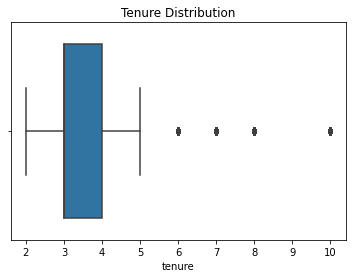

In [12]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
sns.boxplot(x=df['tenure'])
plt.title('Tenure Distribution')
plt.show()




In [13]:
# Determine the number of rows containing outliers

Q1 = df['tenure'].quantile(0.25)
Q3 = df['tenure'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

outlier_count = ((df['tenure'] > upper_bound) | (df['tenure'] < lower_bound)).sum()
print(outlier_count)



824


# pAce: Analyze Stage
- Perform EDA (analyze relationships between variables)



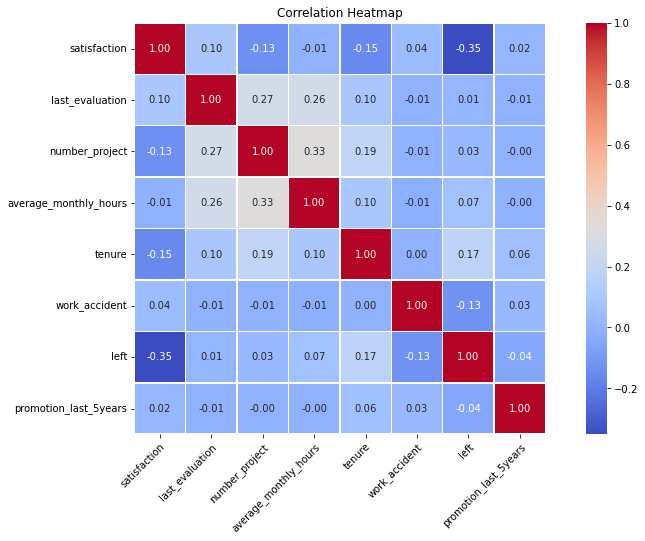

In [14]:
# Create a correlation matrix
corr_matrix = df.corr()

# Convert matrix into a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)

# Title and formatting
plt.title('Correlation Heatmap')
plt.tight_layout()

# Align tick labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

plt.show()


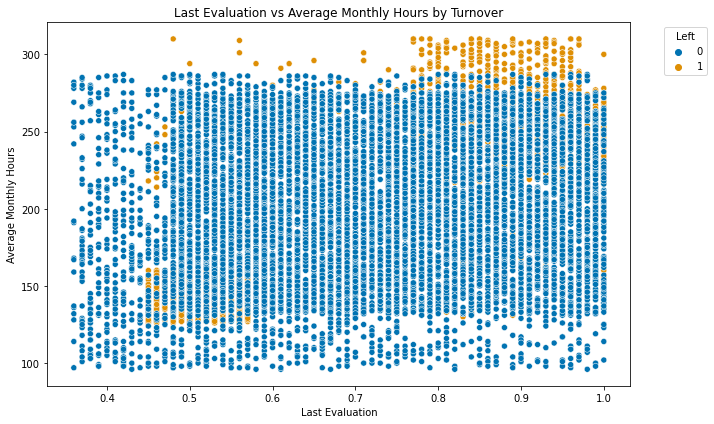

In [15]:
# Create scatterplot for last_evaluation and average_monthly_hours by turnover
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='last_evaluation',    
    y='average_monthly_hours',       
    hue='left',
    palette='colorblind'            
)
# Title and formatting
plt.title('Last Evaluation vs Average Monthly Hours by Turnover')
plt.xlabel('Last Evaluation')
plt.ylabel('Average Monthly Hours')
plt.legend(title='Left', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

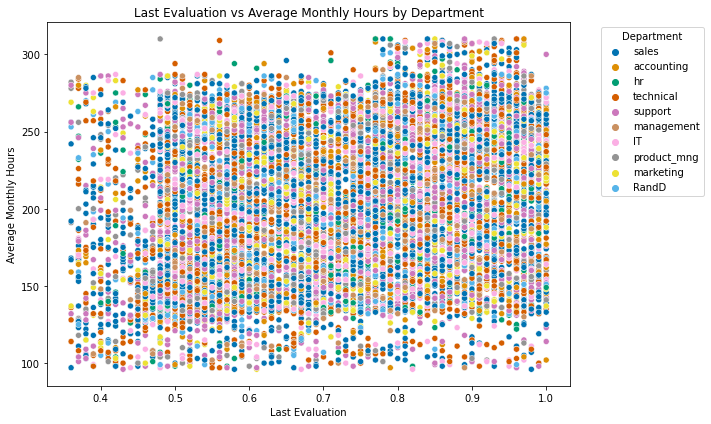

In [16]:
# Create scatterplot for last_evaluation and average_monthly_hours by turnover
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='last_evaluation',    
    y='average_monthly_hours',       
    hue='department',
    palette='colorblind'            
)
# Title and formatting
plt.title('Last Evaluation vs Average Monthly Hours by Department')
plt.xlabel('Last Evaluation')
plt.ylabel('Average Monthly Hours')
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

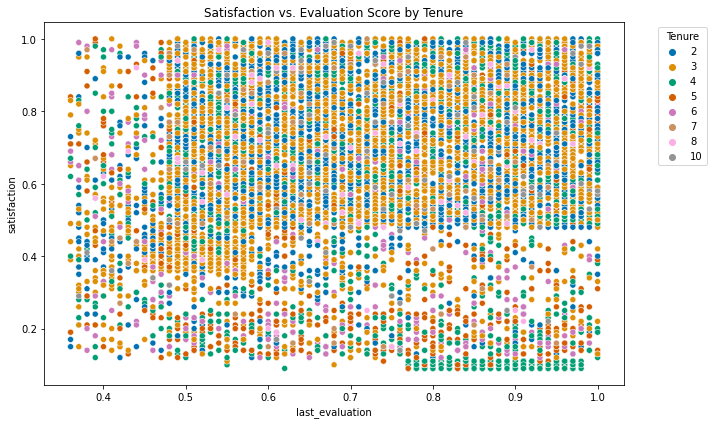

In [17]:
# Create scatterplot for satisfaction vs last_evaluation by tenure 
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='last_evaluation',    
    y='satisfaction',       
    hue='tenure',
    palette='colorblind'            
)
# Title and formatting
plt.title('Satisfaction vs. Evaluation Score by Tenure')
plt.xlabel('last_evaluation')
plt.ylabel('satisfaction')
plt.legend(title='Tenure', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

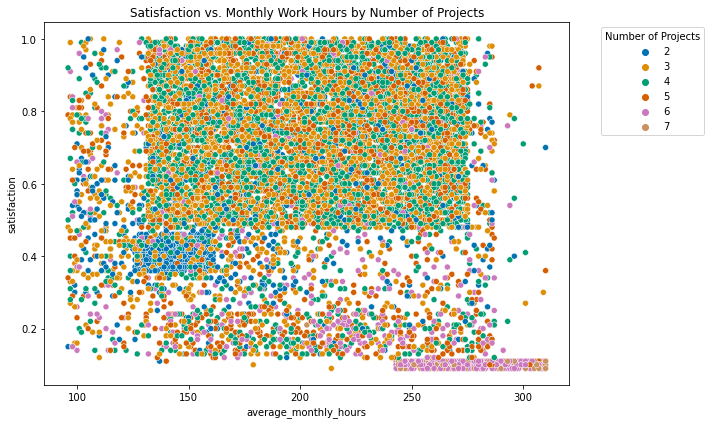

In [18]:
# Create scatterplot showing satisfaction vs average_monthly_hours coded by number_project
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='average_monthly_hours',    
    y='satisfaction',       
    hue='number_project',
    palette='colorblind'            
)

plt.title('Satisfaction vs. Monthly Work Hours by Number of Projects')
plt.xlabel('average_monthly_hours')
plt.ylabel('satisfaction')
plt.legend(title='Number of Projects', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

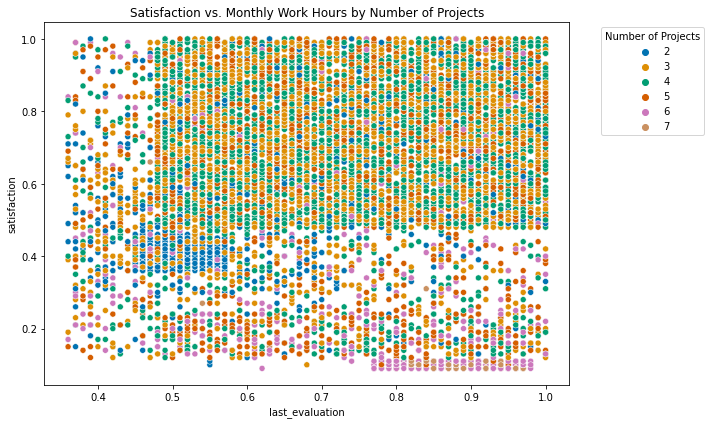

In [19]:
# Scatterplot of satisfaction vs last_evaluation by number_project
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='last_evaluation',    
    y='satisfaction',       
    hue='number_project',
    palette='colorblind'            
)
# Title and formatting
plt.title('Satisfaction vs. Monthly Work Hours by Number of Projects')
plt.xlabel('last_evaluation')
plt.ylabel('satisfaction')
plt.legend(title='Number of Projects', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

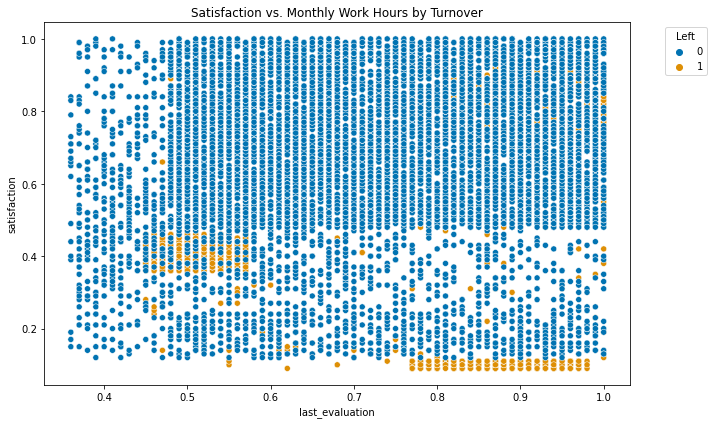

In [20]:
#Scatterplot of satisfaction vs average_monthly_hours by left
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='last_evaluation',    
    y='satisfaction',       
    hue='left',
    palette='colorblind'            
)
# Title and formatting
plt.title('Satisfaction vs. Monthly Work Hours by Turnover')
plt.xlabel('last_evaluation')
plt.ylabel('satisfaction')
plt.legend(title='Left', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

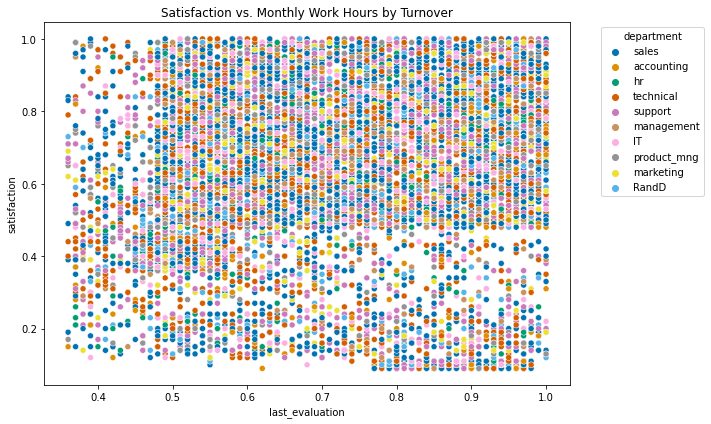

In [21]:
# Scatterplot of satisfaction vs average_monthly_hours by left
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='last_evaluation',    
    y='satisfaction',       
    hue='department',
    palette='colorblind'            
)
#Title and Formatting
plt.title('Satisfaction vs. Monthly Work Hours by Turnover')
plt.xlabel('last_evaluation')
plt.ylabel('satisfaction')
plt.legend(title='department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

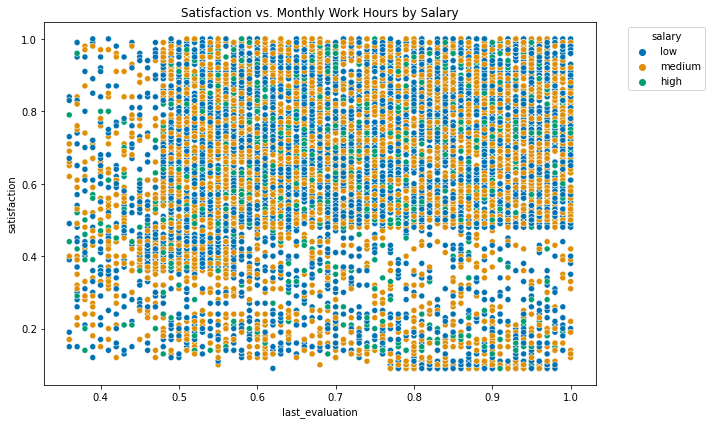

In [22]:
# Scatterplot of satisfaction vs average_monthly_hours by left
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='last_evaluation',    
    y='satisfaction',       
    hue='salary',
    palette='colorblind'            
)
#Title and formatting
plt.title('Satisfaction vs. Monthly Work Hours by Salary')
plt.xlabel('last_evaluation')
plt.ylabel('satisfaction')
plt.legend(title='salary', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Left and satisfaction have the highest (negative) correlation, which comes as no surprise. The next highest correlation (positive) is number_project with average_monthly_hours, which, again, comes as to no surprise as one feeds into the other. After that, both number_project and average_monthly are positively correlated with last_evaluation followed by tenure and number_project.

After getting an idea of correlation between variables, I chose to use a scatterplot between satisfaction and last_evaluation due to the two distinct groups that were separate from the main body of employees. Using different categorical data as hues, I was able to get a general idea of 2 high-turnover employee demographic subsets:
- subset 1: 3-year moderately low-scoring employees with 2 projects and moderately low levels of satisfaction across all departments and salary brackets.
- subset 2: 4-year high-scoring employees with 6 projects and extremely low levels of satisfaction across all departments and salary brackets.
In addition to these subsets, employees who work extreme overtime have extremely high turnovers, likely the same employees with 6 or more projects.

## Step 2. Data Exploration (Continue EDA)


In [23]:
# Get counts and percentages
left_counts = df['left'].value_counts()
left_percentages = df['left'].value_counts(normalize=True).round(3)

# Combine into a DataFrame
turnover_summary = pd.DataFrame({
    'Count': left_counts,
    'Percentage': left_percentages
})

# assign labels
turnover_summary.index = turnover_summary.index.map({0: 'Stayed', 1: 'Left'})

turnover_summary


Count  Percentage
Stayed  10000       0.834
Left     1991       0.166

### Data visualizations

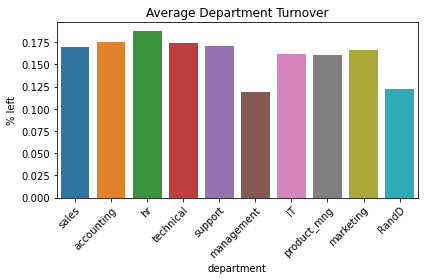

In [24]:
#Create bar plot showing department turnover averages
sns.barplot(x=df['department'], y=df['left'], estimator=np.mean, ci=None)

#Title and formatting
plt.title('Average Department Turnover')
plt.ylabel('% left')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.show();

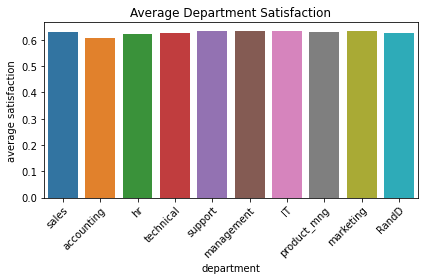

In [25]:
# Create barplot for average department satisfaction
sns.barplot(x=df['department'], y=df['satisfaction'], estimator=np.mean, ci=None)

#Title and formatting
plt.title('Average Department Satisfaction')
plt.ylabel('average satisfaction')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.show();

Management and R&D have the lowest turnover, but nothing startling. However, average satsifaction appears similar across departments.

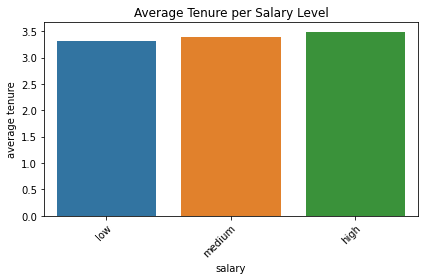

In [26]:
# Create a plot of average tenure per salary level
sns.barplot(x=df['salary'], y=df['tenure'], ci=None)

# Title and formatting
plt.title('Average Tenure per Salary Level')
plt.ylabel('average tenure')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.show();


Salary does not seem to make a large difference in retention. A better measure may be time since the last salary increase.

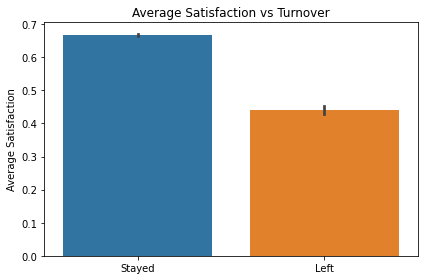

In [27]:
#Create plot of average satisfaction vs turnover
sns.barplot(x='left', y='satisfaction', data=df)

# Title and formatting
plt.title("Average Satisfaction vs Turnover")
plt.xticks([0, 1], ['Stayed', 'Left'])
plt.ylabel('Average Satisfaction')
plt.xlabel('')
plt.tight_layout()
plt.show();

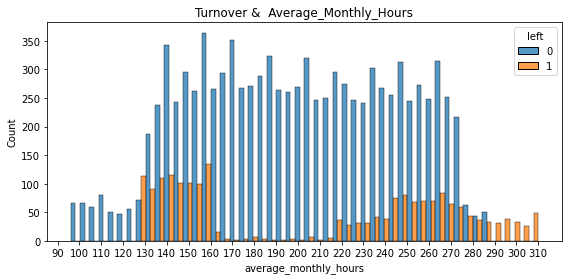

In [28]:
# Create Turnover and average_monthly_hours histplot
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='average_monthly_hours',
    hue='left',
    bins=50,
    multiple='dodge',    #create side-by-side comparison between x(average_monthly_hours) and hue(left)     
    fill=True);

#Title and formatting
plt.title('Turnover &  Average_Monthly_Hours')
plt.xticks(range(90,320, 10))
plt.tight_layout()
plt.show();

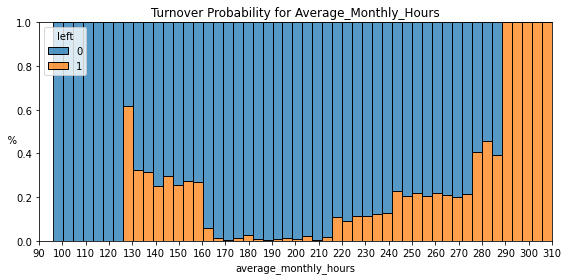

In [29]:
# Modify plot into a probability histplot
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='average_monthly_hours',
    hue='left',
    bins=50,
    multiple='fill',      #create probability aspect of plot   
    fill=True);

# Title and formatting
plt.title('Turnover Probability for Average_Monthly_Hours')
plt.ylabel('%', rotation=180)
plt.xticks(range(90,320, 10))
plt.tight_layout()
plt.show();

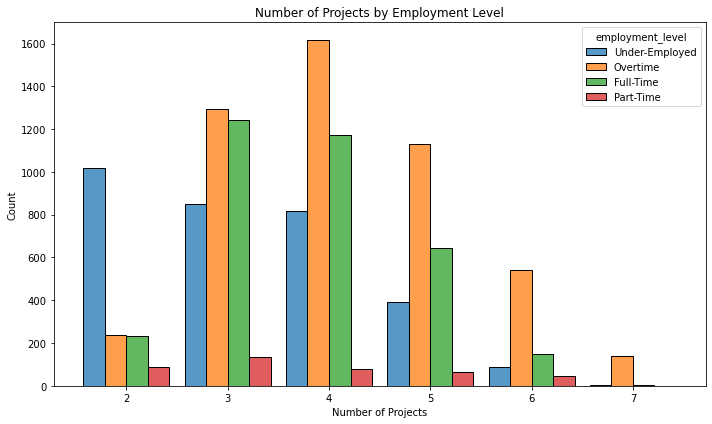

In [30]:
#Subdivide average_monthly hours into categories 
def categorize_hours(hours):
    if hours < 125:
        return 'Part-Time'
    elif 125 <= hours < 165:
        return 'Under-Employed'
    elif 165 <= hours <= 215:
        return 'Full-Time'
    else:
        return 'Overtime'
    
#Assign categories to to average_monthly_hours
df['employment_level'] = df['average_monthly_hours'].apply(categorize_hours)

#Create histogram for number_project by employment_level 
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='number_project',
             hue='employment_level',
             multiple='dodge',               #side-by-side comparison
             shrink=0.85,                    #create space between x-axis groups
             discrete=True)

#Title and formatting
plt.title('Number of Projects by Employment Level')
plt.xlabel('Number of Projects')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [31]:
# Calculate normalized value counts (percentages)
percentages = df.groupby(['number_project', 'employment_level'])['left'].value_counts(normalize=True).unstack(fill_value=0)

# Rename columns for clarity
percentages.columns = ['Stayed (%)', 'Left (%)']
percentages = percentages * 100  # convert to percentage
percentages = percentages.round(1)

# Calculate actual counts
counts = df.groupby(['number_project', 'employment_level'])['left'].value_counts().unstack(fill_value=0)
counts.columns = ['Stayed (Count)', 'Left (Count)']

# Merge the two DataFrames
summary = pd.concat([percentages, counts], axis=1).reset_index()

summary

number_project employment_level  Stayed (%)  Left (%)  Stayed (Count)  \
0                2        Full-Time        97.4       2.6             228   
1                2         Overtime        93.7       6.3             224   
2                2        Part-Time       100.0       0.0              90   
3                2   Under-Employed        18.0      82.0             183   
4                3        Full-Time        99.0       1.0            1230   
5                3         Overtime        98.7       1.3            1277   
6                3        Part-Time       100.0       0.0             134   
7                3   Under-Employed        99.1       0.9             841   
8                4        Full-Time        99.2       0.8            1165   
9                4         Overtime        86.7      13.3            1402   
10               4        Part-Time       100.0       0.0              78   
11               4   Under-Employed        98.5       1.5             803   
12               5        Full-Time        99.1       0.9             639   
13               5         Overtime        71.3      28.7             806   
14               5        Part-Time       100.0       0.0              65   
15               5   Under-Employed        96.9       3.1             380   
16               6        Full-Time        96.0       4.0             144   
17               6         Overtime        35.0      65.0             190   
18               6        Part-Time       100.0       0.0              45   
19               6   Under-Employed        86.4      13.6              76   
20               7        Full-Time         0.0     100.0               0   
21               7         Overtime         0.0     100.0               0   
22               7   Under-Employed         0.0     100.0               0   

    Left (Count)  
0              6  
1             15  
2              0  
3            836  
4             13  
5             17  
6              0  
7              8  
8              9  
9            216  
10             0  
11            12  
12             6  
13           325  
14             0  
15            12  
16             6  
17           353  
18             0  
19            12  
20             2  
21           141  
22             2

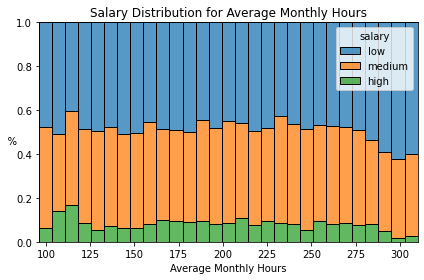

In [96]:
# Create a histplot showing salary proportion of average_monthly_hours
sns.histplot(data=df, x='average_monthly_hours',
             hue='salary', 
             multiple='fill'    #create proportion
            ),
# Title and formatting
plt.ylabel('%', rotation=180)
plt.title('Salary Distribution for Average Monthly Hours' )
plt.xlabel('Average Monthly Hours')
plt.tight_layout()
plt.show();


The largely uniform distribution of salary across average monthly hours (with the exception of a higher percentage of low-salaried employees at the extreme overtime end) combined with the bimodal distribution of turnover probability for average monthly hours, suggests that overtime employees do not have their overtime hours reflected in their salary.

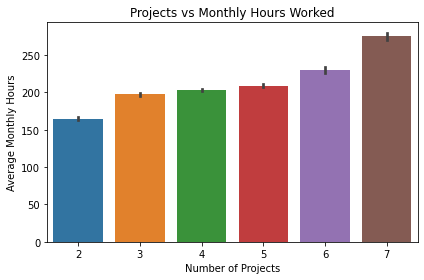

In [33]:
# Create barplot for number_project vs average_monthly_hours
sns.barplot(x='number_project', y='average_monthly_hours', data=df)

# Title and formatting
plt.title('Projects vs Monthly Hours Worked')
plt.xlabel('Number of Projects')
plt.ylabel('Average Monthly Hours')
plt.tight_layout()
plt.show();

In [34]:
# Get percentage of number_projects
df['number_project'].value_counts(normalize=True).sort_index(ascending=True)

2    0.131932
3    0.293553
4    0.307314
5    0.186223
6    0.068885
7    0.012092
Name: number_project, dtype: float64

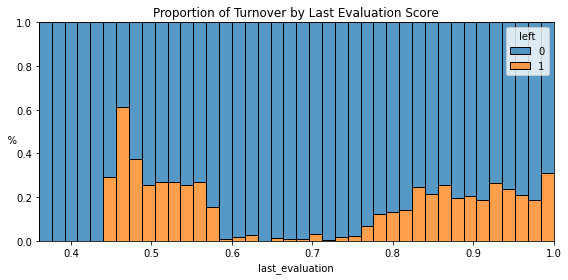

In [35]:
# Create histplot showing turnover proportion of last_evaluation
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='last_evaluation', hue='left', bins=40, multiple='fill')  

# Title and formatting
plt.title('Proportion of Turnover by Last Evaluation Score')
plt.ylabel('%', rotation=180)
plt.tight_layout()
plt.show();


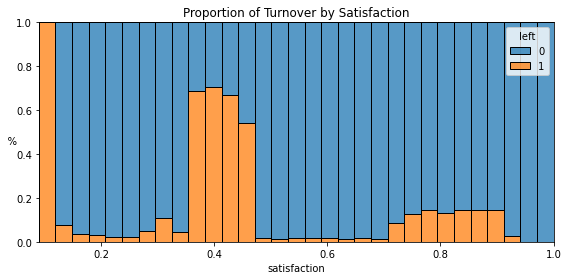

In [36]:
# Create a plot as needed
plt.figure(figsize=(8,4))

sns.histplot(x=df['satisfaction'], 
             hue=df['left'], 
             multiple='fill')       #convert to proportion

# Title and formatting
plt.title('Proportion of Turnover by Satisfaction')
plt.ylabel('%', rotation=180)
plt.tight_layout()
plt.show();


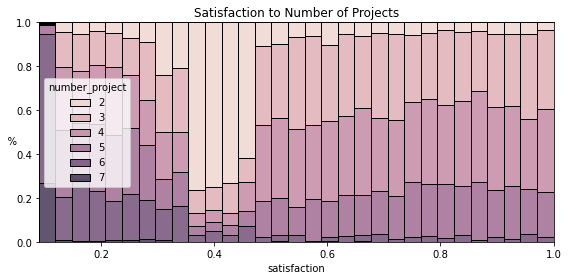

In [37]:
# Create histplot showing proportion of number_projects to satisfaction
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='satisfaction', hue='number_project', multiple='fill'),

# Title and formatting
plt.title('Satisfaction to Number of Projects' )
plt.ylabel('%', rotation=180)
plt.tight_layout()
plt.show();

In [38]:
# Get average satisfaction and turnover for promotion_last_5years
percent = df.groupby('promotion_last_5years')['left'].value_counts(normalize=True).unstack(fill_value=0) * 100
percent.columns = ['Stayed (%)', 'Left (%)']
percent = percent.round(1)
percent

# Calculate average satisfaction for each group
satisfaction = df.groupby(['promotion_last_5years', 'left'])['satisfaction'].mean().unstack()
satisfaction.columns = ['Stayed (Satisfaction)', 'Left (Satisfaction)']
satisfaction = satisfaction.round(2)

# Merge results
summary = pd.concat([percent, satisfaction], axis=1).reset_index()

# Map promotion group to labels
summary['promotion_last_5years'] = summary['promotion_last_5years'].map({0: 'Not Promoted', 1: 'Promoted'})

summary

promotion_last_5years  Stayed (%)  Left (%)  Stayed (Satisfaction)  \
0          Not Promoted        83.2      16.8                   0.67   
1              Promoted        96.1       3.9                   0.67   

   Left (Satisfaction)  
0                 0.44  
1                 0.49

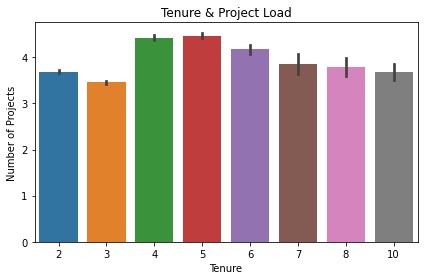

In [39]:
# Create barplot showing tenure vs number_project
sns.barplot(x='tenure', y='number_project',data=df)

# Title and formatting
plt.title('Tenure & Project Load')
plt.xlabel('Tenure')
plt.ylabel('Number of Projects')
plt.tight_layout()
plt.show();

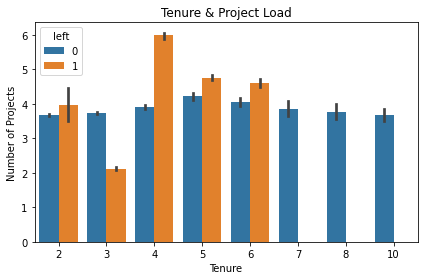

In [40]:
# Create barplot with side-by-side comparison of turnover for tenure by number_project
sns.barplot(data=df,
            x='tenure', 
            y='number_project', 
            hue='left')

#Title and formatting
plt.title('Tenure & Project Load')
plt.xlabel('Tenure')
plt.ylabel('Number of Projects')
plt.tight_layout()
plt.show();

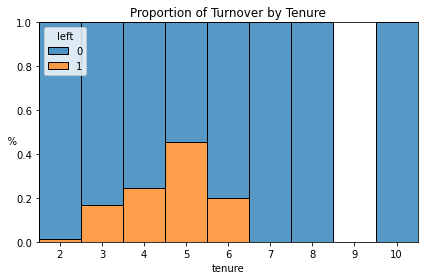

In [41]:
# Create histplot showing proportion of turnover for tenure.
sns.histplot(data=df,
             x='tenure', 
             hue='left', 
             multiple='fill', 
             discrete=True
            )
# Title and formatting
plt.title('Proportion of Turnover by Tenure')
plt.ylabel('%', rotation=180)
plt.tight_layout()
plt.show();

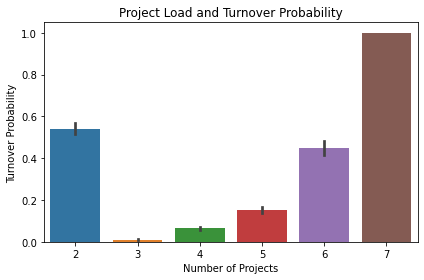

In [97]:
# Create barplot for project_number v. left
sns.barplot(data=df,
            x='number_project', 
            y='left', 
            )

# Title and formatting
plt.title('Project Load and Turnover Probability')
plt.xlabel('Number of Projects')
plt.ylabel('Turnover Probability')
plt.tight_layout()
plt.show();

The promotion_last_5years may not be helpful in our analysis as there is only a class size of 203 (~1.7%) who've been promoted. That said, opportunities for growth could be helpful data to get from HR to use in conjunction with promotions in order to gain a better picture of employee growth on retention. 

In [43]:
# Create table showing count, percentage, and average tenure of left based on number_project category

# Calculate percentage of each 'left' group
group_counts = df.groupby(['number_project', 'left']).size().reset_index(name='count')
project_totals = df.groupby('number_project').size().reset_index(name='total')

# Merge to calculate percentage
merged = pd.merge(group_counts, project_totals, on='number_project')
merged['Percentage'] = (merged['count'] / merged['total']) * 100

# Calculate average number of projects per tenure group
avg_tenure = df.groupby(['number_project', 'left'])['tenure'].mean().reset_index(name='Avg_Tenure')

# Merge both metrics into one table
final = pd.merge(merged, avg_tenure, on=['number_project', 'left'])

# Clean up column names
final = final.rename(columns={
    'number_project': 'Number of Projects',
    'left': 'Left (1=Yes)',
    'Percentage': '% of Project Group',
    'Avg_Tenure': 'Avg Tenure'
})

final

Number of Projects  Left (1=Yes)  count  total  % of Project Group  \
0                    2             0    725   1582           45.828066   
1                    2             1    857   1582           54.171934   
2                    3             0   3482   3520           98.920455   
3                    3             1     38   3520            1.079545   
4                    4             0   3448   3685           93.568521   
5                    4             1    237   3685            6.431479   
6                    5             0   1890   2233           84.639498   
7                    5             1    343   2233           15.360502   
8                    6             0    455    826           55.084746   
9                    6             1    371    826           44.915254   
10                   7             1    145    145          100.000000   

    Avg Tenure  
0     3.380690  
1     3.022170  
2     3.136990  
3     3.842105  
4     3.191705  
5     4.881857  
6     3.348148  
7     5.014577  
8     4.204396  
9     4.094340  
10    4.110345

In [44]:
# Get turnover percentage for number_projects
df[df['left'] == 1]['number_project'].value_counts(normalize=True).sort_index(ascending=True)

2    0.430437
3    0.019086
4    0.119036
5    0.172275
6    0.186339
7    0.072828
Name: number_project, dtype: float64

In [45]:
df.head()

satisfaction  last_evaluation  number_project  average_monthly_hours  \
0          0.38             0.53               2                    157   
1          0.80             0.86               5                    262   
2          0.11             0.88               7                    272   
3          0.72             0.87               5                    223   
4          0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years department  salary  \
0       3              0     1                      0      sales     low   
1       6              0     1                      0      sales  medium   
2       4              0     1                      0      sales  medium   
3       5              0     1                      0      sales     low   
4       3              0     1                      0      sales     low   

  employment_level  
0   Under-Employed  
1         Overtime  
2         Overtime  
3         Overtime  
4   Under-Employed

Spearman correlation: 0.311, p-value: 0.000


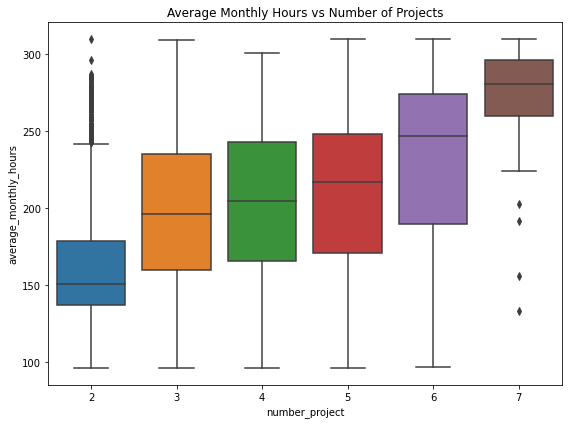

In [46]:
from scipy.stats import spearmanr

# Calculate Spearman correlation
corr, p_value = spearmanr(df['average_monthly_hours'], df['number_project'])
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3f}")

# Visualize with boxplot
plt.figure(figsize=(8,6))
sns.boxplot(data=df,
            x='number_project', 
            y='average_monthly_hours')

# Title and formatting
plt.title('Average Monthly Hours vs Number of Projects')
plt.tight_layout()
plt.show()

In [47]:
# Determine last_evalution categories based on percentiles
df['last_evaluation'].describe()

count    11991.000000
mean         0.716683
std          0.168343
min          0.360000
25%          0.570000
50%          0.720000
75%          0.860000
max          1.000000
Name: last_evaluation, dtype: float64

In [48]:
# Create last_evaluation categories
conditions = [
    (df['last_evaluation'] <= 0.56),
    (df['last_evaluation'] > 0.56) & (df['last_evaluation'] <= 0.72),
    (df['last_evaluation'] > 0.72) & (df['last_evaluation'] <= 0.87),
    (df['last_evaluation'] > 0.87)
]

choices = ['low', 'mod_low', 'mod_high', 'high']

df['eval_category'] = np.select(conditions, choices)




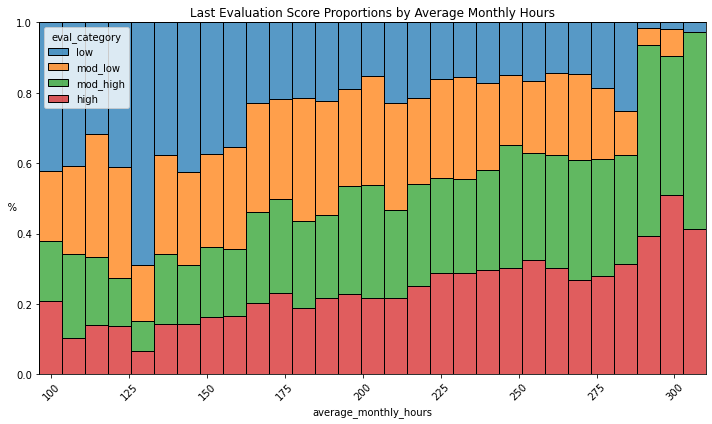

In [49]:
eval_order = ['low', 'mod_low', 'mod_high', 'high']

# Make sure the eval_category column reflects order
df['eval_category'] = pd.Categorical(df['eval_category'], categories=eval_order, ordered=True)
plt.figure(figsize=(10,6))
sns.histplot(
    data=df,
    x='average_monthly_hours',
    hue='eval_category',
    multiple='fill',
    hue_order=eval_order)

# Title and formatting
plt.title('Last Evaluation Score Proportions by Average Monthly Hours')
plt.xticks(rotation=45)
plt.ylabel('%', rotation=180)
plt.tight_layout()
plt.show()


In [50]:
# Drop categorized columns in preparation for model analysis
df=df.drop(['eval_category', 'employment_level'], axis=1)

In [51]:
# Drop features previous EDA and RF models showed as insignificant
df_prepped = df.drop(['salary', 'department'], axis=1)


In [52]:
# Validate 
df_prepped.head()
df.shape


(11991, 10)

### Insights

- It appears that those who work between 160 and 210 hours per week have the lowest turnover.

- There are 2 high-turnover groups: under-employed, 2-project workers; overtime, 6-project workers.

- The largely uniform distribution of salary across average monthly hours, combined with the bimodal distribution of turnover probability for average monthly hours, suggests that average_monthly_hours is a strong variable for further analysis.

- The promotion_last_5years may not be as helpful in our analysis as there is only a class size of 203 out of 11991 (~1.7%) of those who've been promoted. That said, getting data on employee opportunities for growth could paint a clearer picture of the effect of employee growth on retention. 

- The lack of clear linear relationships between variables makes logistic regression a poor fit for the data. A random forest model, which can capture complex nonlinear patterns (as indicated by the bi-modal distribution patterns in the data), would be more appropriate in this case.

## Model Building

This is a binomial prediction task ('stay' vs 'left').

A random forest or an xgb model are the most appropriate models for this task due to the binomial target data, the large proportion of outliers, and the various types of data.

I am including all independent variables as the correlation among data and retention may not be immediately apparent and the random model model will easily allow for the quantity and possible collinearity.

**Update**: I am excluding salary and department to reduce noise in the model since they do not correlate with turnover. I am also excluding satisfaction in the turnover model as that is tied closely to turnover and the other variables, and I wish to evaluate th in its absence.

I chose an XGB model since this is a binomial regression that contains outliers and types of data. The model predicts turnover slightly better than the RF model with an F1 score of 0.934 vs 0.925. The only thing I would change about the model is to incorporate more features to better understand why people at the 4-year mark are leaving. The promotion_last_5_years metric is promising; however, due to the low number of promotions (which may be the answer in and of itself), it did not carry much weight in the modeling even though those who were promoted were ~75% less likely to leave than their counterparts eventhough the average satisfaction was the same between the groups.

I found myself using ChatGPT to quickly check for code errors, rewrite code to save time, refresh my memory of syntax, and discover useful code modifications. (I completed 4 models that each needed unique names that got a little too long for ease and as such were prone to errors).

# Modeling



### RF Left Model

In [53]:
# Instantiate RF
rf=RandomForestClassifier(random_state=42)

# Create cross-validation parameters
cv_params = {'max_depth': [3, 5, 7 ],
             'min_samples_leaf':[1, 2],
             'min_samples_split': [2, 5],
             'max_features':[2, 5, None],
             'n_estimators':[100, 150]
            }
# Create scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate GridsearchCV
rf_cv=GridSearchCV(estimator=rf, param_grid=cv_params, scoring=scoring, cv=5, refit='f1')




In [54]:
# Assign values for fitting
y=df_prepped['left']
X = df_prepped.drop(['left', 'satisfaction'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


df_prepped.head()

satisfaction  last_evaluation  number_project  average_monthly_hours  \
0          0.38             0.53               2                    157   
1          0.80             0.86               5                    262   
2          0.11             0.88               7                    272   
3          0.72             0.87               5                    223   
4          0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  
0       3              0     1                      0  
1       6              0     1                      0  
2       4              0     1                      0  
3       5              0     1                      0  
4       3              0     1                      0

In [55]:
#Fit model
#rf_cv.fit(X_train, y_train)

In [56]:
# Pickle RF Results
#with open('rf_cv.pkl', 'wb') as file:
    #pickle.dump(rf_cv, file)


In [57]:
# Open Picked RF Results
with open('rf_cv.pkl', 'rb') as file:
    rf_cv = pickle.load(file)
rf_cv

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [58]:
# RF model predictions
y_pred_test= rf_cv.predict(X_test)
y_pred_train = rf_cv.predict(X_train)



In [59]:
metrics = {
    'Accuracy': [accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)],
    'Precision': [precision_score(y_train, y_pred_train), precision_score(y_test, y_pred_test)],
    'Recall': [recall_score(y_train, y_pred_train), recall_score(y_test, y_pred_test)],
    'F1 Score': [f1_score(y_train, y_pred_train), f1_score(y_test, y_pred_test)],
}

# Create a DataFrame
comparison_df = pd.DataFrame(metrics, index=['Train', 'Test'])
comparison_df = comparison_df.round(3)
comparison_df

Accuracy  Precision  Recall  F1 Score
Train     0.977      0.947   0.911     0.929
Test      0.976      0.945   0.906     0.925

In [60]:
# Create result table

# Calculate metrics
acc = accuracy_score(y_test, y_pred_test) 
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# Create DataFrame with scores as columns
results = pd.DataFrame({
    'Accuracy': [acc],
    'Precision': [prec],
    'Recall': [rec],
    'F1': [f1]
}, index=['Random Forest Left'])

# Round to 3 decimal places
results = results.round(3)

results

Accuracy  Precision  Recall     F1
Random Forest Left     0.976      0.945   0.906  0.925

[[2474   26]
 [  47  451]]


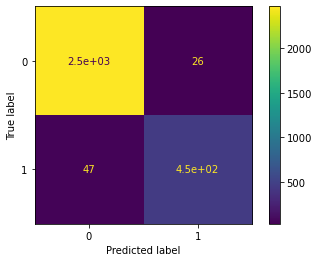

In [61]:
# Create confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

cm= confusion_matrix(y_test, y_pred_test)

# Display matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
print(disp.plot())
print(cm)

number_project           0.334443
average_monthly_hours    0.262734
tenure                   0.202934
last_evaluation          0.187981
work_accident            0.010763
promotion_last_5years    0.001145
dtype: float64


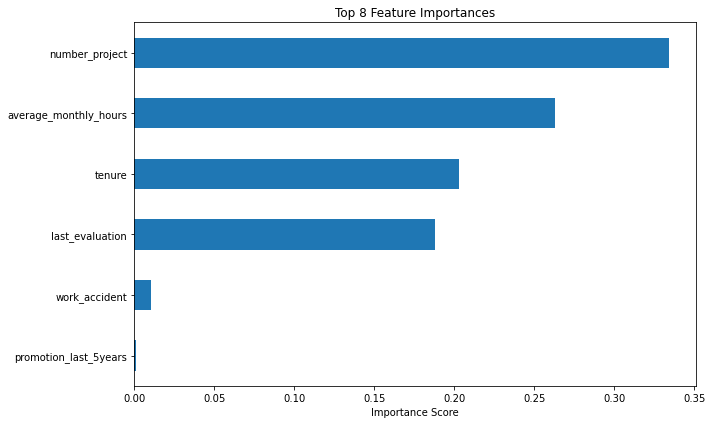

In [62]:
# Get feature importances from the best model
importances = rf_cv.best_estimator_.feature_importances_

# Match them with feature names
feature_names = X_train.columns
feat_importances = pd.Series(importances, index=feature_names)

# Sort and display
feat_importances = feat_importances.sort_values(ascending=False)

# Display as a table
print(feat_importances)

# Plot the top features
plt.figure(figsize=(10,6))
feat_importances.head(8).plot(kind='barh')

# Title and Formatting
plt.title('Top 8 Feature Importances')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


The top five features with the most impact on turnover were 'number_project', 'average_monthly_hours', 'tenure', and 'last_evaluation'. As EDA and a previous RF model signaled that 'department' and 'salary' did not correlate with turnover, those two features were eliminated to reduce noise as was satisfaction since that is so highly correlated with turnover, as also confirmed in the previous RF model where satisfaction was the largest predictor of employee retention by nearly double.

Analyzing the features that drive employee satisfaction to compare/contrast is a next logical step. A random forest regression model will be deployed specifically for satisfaction followed by an XGBoost model.

### XGBoost Left Model

In [63]:
# Instantiate XGB_left

xgb_left_base = XGBClassifier(objective='binary:logistic', random_state=42)

# Define scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Define hyperparameters
xgb_sat_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Instantiate GridSearchCV
xgb_left_cv = GridSearchCV(
    estimator=xgb_left_base,
    param_grid=xgb_sat_params,
    scoring=scoring,
    refit='f1',
    cv=5
)

# Assign values for fitting
y_left = df_prepped['left']
X_left = df_prepped.drop(['left','satisfaction'], axis=1)

X_train_left, X_test_left, y_train_left, y_test_left = train_test_split(
    X_left,
    y_left,
    test_size=0.25,
    random_state=42,
    stratify=y_left
)


In [64]:
# Fit model
#xgb_left_cv.fit(X_left, y_left) 

In [65]:
# Pickle model results
#with open('xgb_left_cv.pkl', 'wb') as file:
    #pickle.dump(xgb_left_cv, file)

In [66]:
# Open saved pickle
with open('xgb_left_cv.pkl', 'rb') as file:  # 'rb' means read binary
    xgb_left_cv = pickle.load(file)
xgb_left_cv

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.8], 'learning_rate': [0.1],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100],
                         'subsample': [0.8]},
             pre_dispatch='2*n_jobs', ref

In [67]:
# XGBoost predictions
y_xgb_left_train_pred = xgb_left_cv.predict(X_train_left)
y_xgb_left_test_pred = xgb_left_cv.predict(X_test_left)

# Compare f1 scores
f1=f1_score(y_train_left, y_xgb_left_train_pred)
print("F1 Train Score", round(f1, 3))
f1=f1_score(y_test_left, y_xgb_left_test_pred)
print("F1 Test Score", round(f1,3))


F1 Train Score 0.93
F1 Test Score 0.934


In [68]:
# Calculate metrics
acc_xgb_left = accuracy_score(y_test_left, y_xgb_left_test_pred)
prec_xgb_left = precision_score(y_test_left, y_xgb_left_test_pred)
rec_xgb_left = recall_score(y_test_left, y_xgb_left_test_pred)
f1_xgb_left = f1_score(y_test_left, y_xgb_left_test_pred)


# Create DataFrame for XGBoost
xgb_results_left = pd.DataFrame({
    'Accuracy': [acc_xgb_left],
    'Precision': [prec_xgb_left],
    'Recall': [rec_xgb_left],
    'F1': [f1_xgb_left]
}, index=['XGBoost Left'])
# Round to 3 decimal places
xgb_results_left = xgb_results_left.round(3)

# Append to original results
results = pd.concat([results, xgb_results_left])

results

Accuracy  Precision  Recall     F1
Random Forest Left     0.976      0.945   0.906  0.925
XGBoost Left           0.978      0.945   0.924  0.934

[[2473   27]
 [  38  460]]


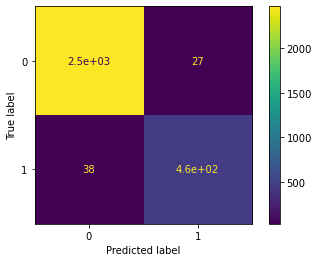

In [69]:
cm_xgb_left= confusion_matrix(y_test_left, y_xgb_left_test_pred)

# Display matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_left, display_labels=[0, 1])
print(disp.plot())
print(cm_xgb_left)

In [70]:
# Show best model parameters
print("Best parameters:", xgb_left_cv.best_params_)

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


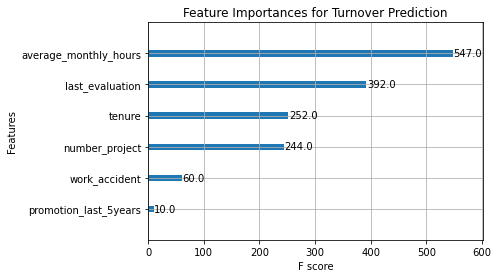

In [71]:
# Find best model
best_model = xgb_left_cv.best_estimator_

# Plot feature importances from that model
plot_importance(best_model)
plt.title("Feature Importances for Turnover Prediction")
plt.show()


                 Feature  Importance
0         number_project    0.330583
1                 tenure    0.266280
2        last_evaluation    0.188066
3  average_monthly_hours    0.155705
4          work_accident    0.040284
5  promotion_last_5years    0.019082


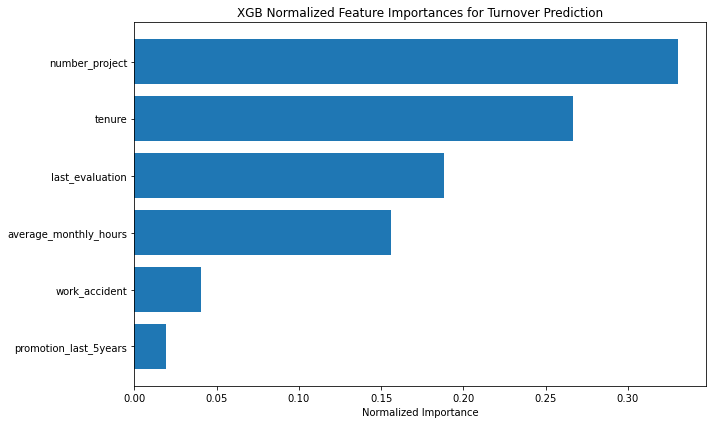

In [72]:
# Normalize feature importances
xgb_left_importance = xgb_left_cv.best_estimator_.feature_importances_
xgb_left_importance_normalized = xgb_left_importance / xgb_left_importance.sum()
xgb_left_importance_df = pd.DataFrame({
    'Feature': X_train_left.columns,
    'Importance': xgb_left_importance_normalized
})

# Sort the features by importance descending
xgb_left_importance_df = xgb_left_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# View results
print(xgb_left_importance_df)

# Create bargraph representation
plt.figure(figsize=(10, 6))
plt.barh(xgb_left_importance_df['Feature'], 
         xgb_left_importance_df['Importance'])
plt.xlabel('Normalized Importance')
plt.title('XGB Normalized Feature Importances for Turnover Prediction')
plt.gca().invert_yaxis()  # Most important feature at the top
plt.tight_layout()
plt.show()

The RF and XGBoost models show 'satisfaction' as the largest predictor of turnover. Further RF/XGBoost modeling will allow me to determine the strongest predictors of satisfaction. In order to use those models on 'satisfaction', I need to turn it into a binary feature.

### RF Satisfaction Model

In [73]:
# Determine threshold for dissatisfaction
df_prepped.groupby('left')['satisfaction'].mean()

left
0    0.667365
1    0.440271
Name: satisfaction, dtype: float64

In [74]:
#create df making target a binomial

df_sat=df_prepped.copy()
df_sat['satisfaction'] = np.where(df_sat['satisfaction'] < 0.45, 1, 0)


df_sat.head()

satisfaction  last_evaluation  number_project  average_monthly_hours  \
0             1             0.53               2                    157   
1             0             0.86               5                    262   
2             1             0.88               7                    272   
3             0             0.87               5                    223   
4             1             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  
0       3              0     1                      0  
1       6              0     1                      0  
2       4              0     1                      0  
3       5              0     1                      0  
4       3              0     1                      0

In [75]:
# Instantiate RF
rf_sat=RandomForestClassifier(random_state=42)
#Creating cross-validation parameters
cv_rf_sat_params = {'max_depth': [3, 5, 7 ],
             'min_samples_leaf':[1, 2],
             'min_samples_split': [2, 5],
             'max_features':[2, 5, None],
             'n_estimators':[100, 150]
            }
# Create scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']
rf_sat_cv=GridSearchCV(estimator=rf_sat, param_grid=cv_rf_sat_params, scoring=scoring, cv=5, refit='recall')


In [76]:
# Assign and train data
X_sat=df_sat.drop(['satisfaction', 'left'],axis=1)
y_sat=df_sat['satisfaction']

X_sat_train, X_sat_test, y_sat_train, y_sat_test = train_test_split(
    X_sat,
    y_sat,
    test_size=0.25,
    stratify=y_sat,
    random_state=42)

In [77]:
# Fit to model
#rf_sat_cv.fit(X_sat_train, y_sat_train)

In [78]:
# Pickle model results
#with open('rf_sat_cv.pkl', 'wb') as file:
    #pickle.dump(rf_sat_cv, file)

In [79]:
# Open saved pickle
with open('rf_sat_cv.pkl', 'rb') as file:  # 'rb' means read binary
    rf_sat_cv = pickle.load(file)
rf_sat_cv

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [80]:
# Show best model parameters
print("Best Parameters:", rf_sat_cv.best_params_)

Best Parameters: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [81]:
# Training set performance
y_sat_train_pred = rf_sat_cv.predict(X_sat_train)
train_sat_f1 = f1_score(y_sat_train, y_sat_train_pred)

# Test set performance
y_sat_test_pred = rf_sat_cv.predict(X_sat_test)
test_sat_f1 = f1_score(y_sat_test, y_sat_test_pred)

print(f"F1 Score (Train): {train_sat_f1:.3f}")
print(f"F1 Score (Test):  {test_sat_f1:.3f}")



F1 Score (Train): 0.721
F1 Score (Test):  0.639


In [82]:
rf_sat_results = pd.DataFrame({
    "Accuracy": [accuracy_score(y_sat_test, y_sat_test_pred)],
    "Precision": [precision_score(y_sat_test, y_sat_test_pred)],
    "Recall": [recall_score(y_sat_test, y_sat_test_pred)],
    "F1": [f1_score(y_sat_test, y_sat_test_pred)]
}, index=['Random Forest Satisfaction'])

rf_sat_results = rf_sat_results.round(3)
results = pd.concat([results, rf_sat_results])
results

Accuracy  Precision  Recall     F1
Random Forest Left             0.976      0.945   0.906  0.925
XGBoost Left                   0.978      0.945   0.924  0.934
Random Forest Satisfaction     0.865      0.787   0.538  0.639

[[2234   97]
 [ 308  359]]


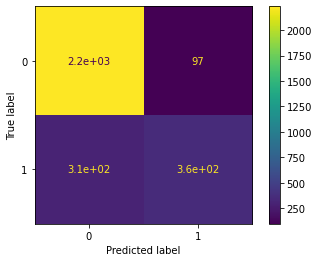

In [83]:
cm_rf_sat= confusion_matrix(y_sat_test, y_sat_test_pred)

# Display matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_sat, display_labels=[0, 1])
print(disp.plot())
print(cm_rf_sat)

number_project           0.334443
average_monthly_hours    0.262734
tenure                   0.202934
last_evaluation          0.187981
work_accident            0.010763
promotion_last_5years    0.001145
dtype: float64


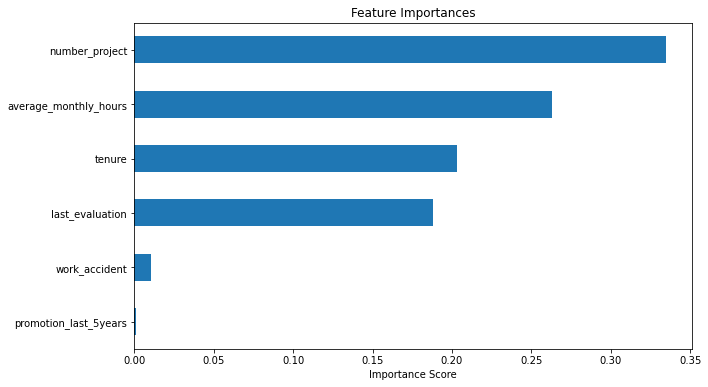

In [84]:
# Get feature importances from the best model
importances_rf_sat = rf_sat_cv.best_estimator_.feature_importances_

# Match them with feature names
feature_names_rf_sat = X_train.columns
feat_importances_rf_sat = pd.Series(importances_rf_sat, index=feature_names_rf_sat)

# Sort and display
feat_importances_rf_sat= feat_importances.sort_values(ascending=False)

# Display as a table
print(feat_importances_rf_sat)

# Plot the top features
plt.figure(figsize=(10,6))
feat_importances.head(6).plot(kind='barh')
plt.title('Feature Importances')
plt.gca().invert_yaxis()                   # Make barplot horizontal
plt.xlabel('Importance Score')
plt.show()


### XGBoost Satisfaction Model

In [85]:
# Instantiate model
xgb_sat = XGBClassifier(objective='binary:logistic', random_state=0)

# Set parameters
xgb_sat_params = {
    'n_estimators': [50, 100],                # Keep it light to reduce runtime
    'max_depth': [3, 4],                      # Shallower trees = less overfitting
    'learning_rate': [0.05, 0.1],             # Lower LR can improve generalization
    'subsample': [0.8],                       # Already a good regularizer
    'colsample_bytree': [0.8],                # Ditto
    'min_child_weight': [3, 5],               # Helps avoid overly specific splits
    'gamma': [0, 0.1],                        # Penalizes overly complex splits
    'reg_alpha': [0, 0.1],                    # L1 regularization (feature sparsity)
    'reg_lambda': [1]                         # L2 regularization (weight shrinkage)
}

# Assign Variables
y_xgb_sat = df_sat['satisfaction']
X_xgb_sat = df_sat.drop(['satisfaction', 'left'], axis=1)

# 🛠 FIX train_test_split
X_xgb_sat_train, X_xgb_sat_test, y_xgb_sat_train, y_xgb_sat_test = train_test_split(
    X_xgb_sat,
    y_xgb_sat,
    test_size=0.25,
    stratify=y_xgb_sat,
    random_state=42
)

# Scoring
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Grid search with refit on F1
xgb_sat_cv = GridSearchCV(
    estimator=xgb_sat,
    param_grid=xgb_sat_params,
    scoring=scoring,
    cv=5,
    refit='recall'
)

In [86]:
#xgb_sat_cv.fit(X_xgb_sat_train, y_xgb_sat_train)

In [87]:
#with open('xgb_sat_cv.pkl', 'wb') as file:
   #pickle.dump(xgb_sat_cv, file)
    


In [88]:
with open('xgb_sat_cv.pkl', 'rb') as file:
    xgb_sat_cv = pickle.load(file)
xgb_sat_cv

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.8], 'gamma': [0, 0.1],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 4],
                         'min_child_weight': [3, 5], 'n_estimators': [50, 100],
            

In [89]:
# Get best model parameters
print("Best parameters:", xgb_sat_cv.best_params_)

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}


In [90]:
# Predict on train and test
y_xgb_sat_train_pred = xgb_sat_cv.predict(X_xgb_sat_train)
y_xgb_sat_test_pred = xgb_sat_cv.predict(X_xgb_sat_test)

# Calculate metrics
train_xgb_sat_f1 = f1_score(y_xgb_sat_train, y_xgb_sat_train_pred)
test_xgb_sat_f1 = f1_score(y_xgb_sat_test, y_xgb_sat_test_pred)

print(f"F1 Score (Train): {train_xgb_sat_f1:.3f}")
print(f"F1 Score (Test): {test_xgb_sat_f1:.3f}")

F1 Score (Train): 0.689
F1 Score (Test): 0.629


In [91]:
y_xgb_sat_pred= xgb_sat_cv.predict(X_xgb_sat_test)

xgb_sat_results = pd.DataFrame({
    "Accuracy": [accuracy_score(y_xgb_sat_test, y_xgb_sat_pred)],
    "Precision": [precision_score(y_xgb_sat_test, y_xgb_sat_pred)],
    "Recall": [recall_score(y_xgb_sat_test, y_xgb_sat_pred)],
    "F1": [f1_score(y_xgb_sat_test, y_xgb_sat_pred)]
}, index=['XGBoost Satisfaction'])

xgb_sat_results = xgb_sat_results.round(3)
results = pd.concat([results, xgb_sat_results])
results

Accuracy  Precision  Recall     F1
Random Forest Left             0.976      0.945   0.906  0.925
XGBoost Left                   0.978      0.945   0.924  0.934
Random Forest Satisfaction     0.865      0.787   0.538  0.639
XGBoost Satisfaction           0.860      0.763   0.535  0.629

[[2220  111]
 [ 310  357]]


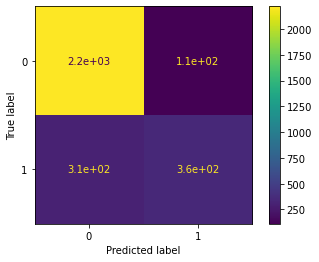

In [92]:
cm_xgb_sat= confusion_matrix(y_xgb_sat_test, y_xgb_sat_pred)

# Display matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_sat, display_labels=[0, 1])
print(disp.plot())
print(cm_xgb_sat)

                 Feature  Importance
0         number_project    0.549714
1                 tenure    0.147312
2  average_monthly_hours    0.122781
3        last_evaluation    0.118669
4  promotion_last_5years    0.035583
5          work_accident    0.025942


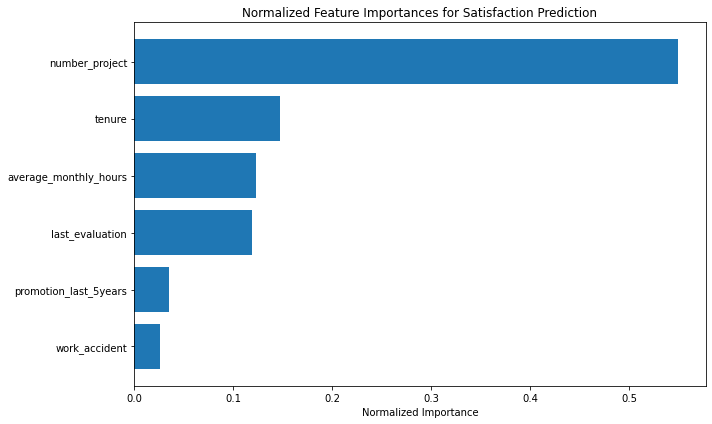

In [93]:
# Get feature importances
xgb_sat_importance = xgb_sat_cv.best_estimator_.feature_importances_
xgb_sat_importance_normalized = xgb_sat_importance / xgb_sat_importance.sum()

# Create a DataFrame of importances
xgb_sat_importance_df = pd.DataFrame({
    'Feature': X_xgb_sat_train.columns,
    'Importance': xgb_sat_importance_normalized
})

# Sort by importance
xgb_sat_importance_df = xgb_sat_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# View results
print(xgb_sat_importance_df)

# Plot the importances
plt.figure(figsize=(10, 6))
plt.barh(xgb_sat_importance_df['Feature'], xgb_sat_importance_df['Importance'])
plt.xlabel('Normalized Importance')
plt.title('Normalized Feature Importances for Satisfaction Prediction')
plt.gca().invert_yaxis()  # Most important feature at the top
plt.tight_layout()
plt.show()

## Key Insights: 
- Higher evaluation scores tended to go to overworked employees.
- Project load was the best predictor of turnover with 3-4 projects being the sweet spot and the bookends driving turnover.
- Employees tended to leave after 4 years.
- Promotions aren't happening frequently enough to even use it as a metric for evaluating turnover.
- Employees who worked 125-165 hours or more than 215 hours were much more likely to leave.
Potential Recommendations:
- Redistribute project loads, capping them at 4 or 5.
- Promote more within the company, which could create more data to determine promotion's relationship to turnover and possibly improve turnover at the same time.
Other questions I could address for the team:
- I could take a deeper dive to see if those not working overtime (~160 hours) are being penalized with lower evaluation scores. 
My model could be improved with additional data, such as identifying which employees were laid-off versus which voluntarily left. 
I don't find myself using any resources in this stage other than referencing syntax for models.
There are no ethical considerations in this stage.


## Results and Evaluation
- Interpret model
- Evaluate model performance using metrics
- Prepare results, visualizations, and actionable steps to share with stakeholders




In [94]:
# Display model results
results

Accuracy  Precision  Recall     F1
Random Forest Left             0.976      0.945   0.906  0.925
XGBoost Left                   0.978      0.945   0.924  0.934
Random Forest Satisfaction     0.865      0.787   0.538  0.639
XGBoost Satisfaction           0.860      0.763   0.535  0.629

### Conclusion, Recommendations, Next Steps

Key Insights:
- Number_project is the leading predictor of turnover followed closely by tenure. 
- Unsurprisingly, number_load correlates with average_monthly_hours. What is interesting is employees working 165 to 210 hours per week have the lowest turnover while those working between 125 and 160 and above 220 have higher turnovers. Also, those who work only two projects and those who work more than five are more likely to leave than stay. This points to two distinct turnover demographics: overworked and underworked.
- Underemployed workers with only 2 projects had the highest turnover rate (82%) and were the highest drivers of total turnover.
- Underemployed workers with 3 projects only had a 0.9% turnover rate.
- Last_evaluations are positively correlated with average_monthly_hours and number_project, indicating a culture that rewards overworking, which comes at the expense of employee satisfaction.
- Employees with 3-4 projects were the most likely to be retained; however employees with 5 projects were as satisfied as those with 3-4 projects but left at higher rates.
- Employees with 5 years tenure are more likely to leave than stay.
- There are not enough in-house promotions to use promotion_last_5years as a meaningful feature, which in and of itself may point to a lack of promotions as being a factor in 5-year employee turnover.
Recommendations:
- Update employee project load guidelines: cap at 4 for optimal employee satisfaction, shifting project loads so fulltime employees have at least 3 projects. 
- Focus on in-house promotions in order to accumulate promotion data for further analysis. 
- Address company culture issues that are resulting in evaluation scores being tied to average monthly hours by creating company culture training for managers and employees. 
Next Steps:
- Gather more data to determine why 4-5 year employees are leaving at such high rates. My data wishlist: experience level when hired, data on employee skill investment initiatives, sick days taken, paid time off taken, unpaid time off, exit interview data, and overtime guidelines/compensation (if any).